## Sentiment analysis with few plots for the EDA

### Importing Libraries

In [1]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

### Reading the dataset from scraping.ipynb

In [2]:
df = pd.read_csv('data.csv')
df['Title'] = df['Title'].astype(str)
df['Body'] = df['Body'].astype(str)
df['Stars'] = df['Stars'].astype(int)

### Removing Stopwords

The stopwords are words that are filtered out before, or after, the actual words in the text that carry the information. In fact, most stop words have no particular meaning when isolated from the text. 

For the further modelling I still included the stopwords since sometimes they remove some context in the phrase.

In [3]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w not in stopwords]

### Most common words in titles and bodies

The function FreqDist creates a dictionary as per key the word and as value the number of times that word accurs in the text

In [4]:
fd_title = nltk.FreqDist(words_title_clear)

sorted_fd_title = dict(sorted(fd_title.items(), key=lambda item: item[1], reverse=True)) # sorting the dictionary based on the key (number of occurences per word)

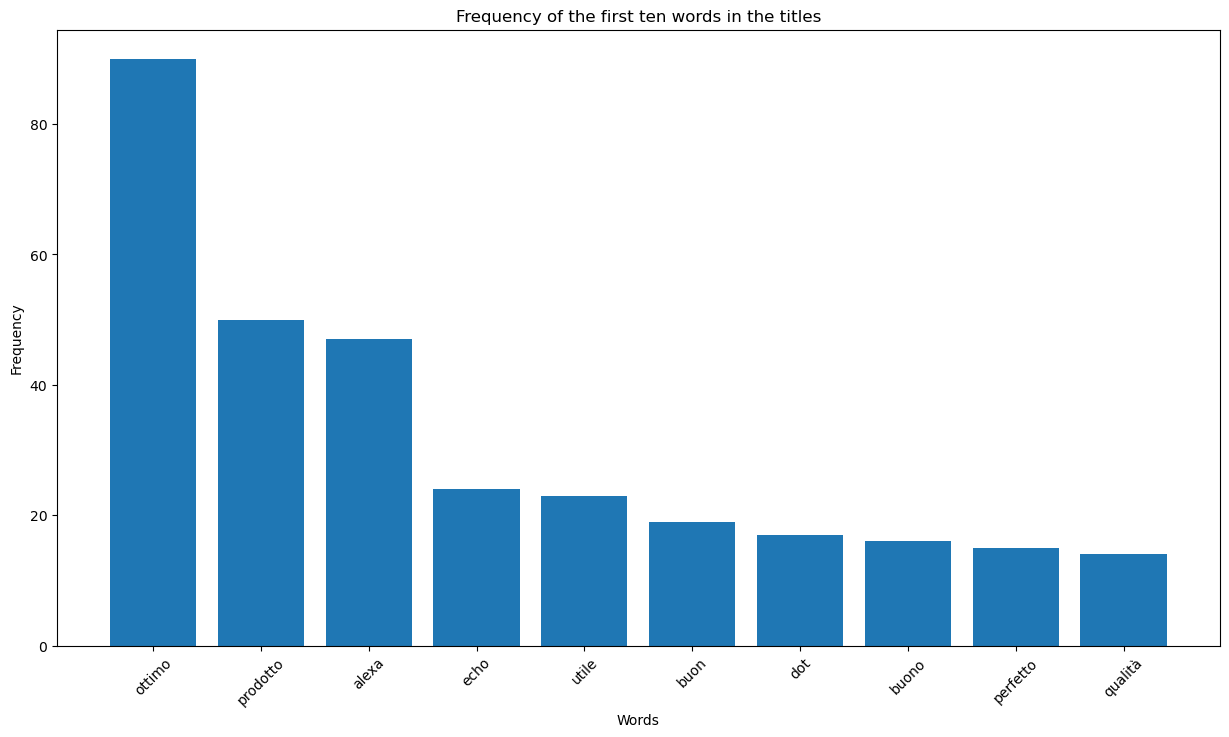

In [5]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the titles')
plt.bar(list(sorted_fd_title.keys())[:10], list(sorted_fd_title.values())[:10])
plt.show()

In [6]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]

In [7]:
fd_body = nltk.FreqDist(words_body_clear)

sorted_fd_body = dict(sorted(fd_body.items(), key=lambda item: item[1], reverse=True))

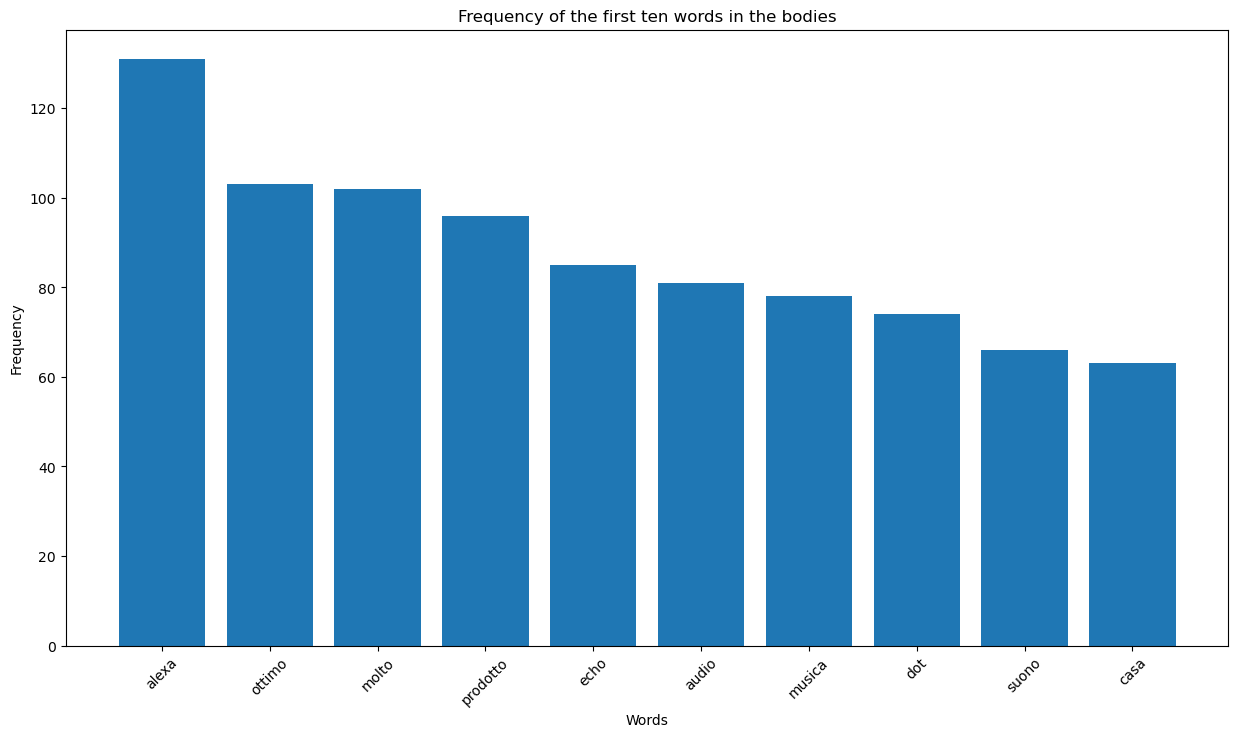

In [8]:
plt.figure(figsize=(15,8))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Frequency of the first ten words in the bodies')
plt.bar(list(sorted_fd_body.keys())[:10], list(sorted_fd_body.values())[:10])
plt.show()

### Review classification

Here I calculate the polarity of every review. 

To do that I used the function polarity_scores() that returns me a dictionary composed of the negative, neutral, positive and compound polarity of the text I gaver as input.

In [3]:
sia = SentimentIntensityAnalyzer()
title_polarity = [sia.polarity_scores(str(element)) for element in df['Title']]
body_polarity = [sia.polarity_scores(str(element)) for element in df['Body']]

Here I choose the polarity through the compound value, since it is the most consistent. When the compund value is 0.0 it means that the text is fully neutral, so I give as score 0.5

In [4]:
title_pol_mean = []

for i in range(len(title_polarity)):
    if title_polarity[i]['compound'] == 0.0:
        title_pol_mean.append(0.5)
    else:
        title_pol_mean.append(title_polarity[i]['compound'])

In [5]:
body_pol_mean = []

for i in range(len(body_polarity)):
    if body_polarity[i]['compound'] == 0.0:
        body_pol_mean.append(0.5)
    else:
        body_pol_mean.append(body_polarity[i]['compound'])

After getting all the polarities of the titles and the bodies I decided to compute a weighted average of the different polarity scores of titles and bodies. I use as weight 0.2 (20% for the titles) and 0.8 (80%) for the bodies. Usually someone could think that should be the opposite since the titled explains in a better and shorter way the sentiment of a phrase, but since I resulted with mainly neutral titles I did the opposite.

In [6]:
total_polarity = []
total_polarity = [round((i*0.2 + j*0.8)/2, 4) for i,j in zip(title_pol_mean, body_pol_mean)] # weighted average to calculate the total polarity

In [7]:
df['Polarity'] = total_polarity

I assigned a keyword to every review according to the value of the polarity

In [8]:
list_polarity = []
for i in range(len(df)):
    if df['Polarity'][i] < 0:
        list_polarity.append('Bad')
    elif df['Polarity'][i] <= 0.15:
        list_polarity.append('Neutral')
    else:
        list_polarity.append('Good')

df['Polarity_Text'] = list_polarity

In [9]:
df['Polarity_Text'].value_counts()

Good       406
Bad         66
Neutral     38
Name: Polarity_Text, dtype: int64

Here I joined the titles and the bodies to get a full review since I used both to calculate the polarity and also because for further processing I will need the full text

In [10]:
df['Full Review'] = df.apply(lambda row: row['Title'] + ' ' + row['Body'], axis=1) # joining titles and bodies in orderto get a full text 

In [21]:
df.sample(10)

,Title,Body,Stars,Polarity,Polarity_Text,Full Review
89,alexa gen ottimo come gli altri alexa,ho perso il conto di quanti echo dot ho compra...,5,0.2500,Good,alexa gen ottimo come gli altri alexa ho per...
310,inimitabile,bello piccolo e potente utile e versatile t...,5,0.2500,Good,inimitabile bello piccolo e potente utile e ...
263,ottimo,da scoprire le funzionalità del dispositivo,4,0.2500,Good,ottimo da scoprire le funzionalità del disposi...
24,è un regalo,l ho scelto come regalo per ora era felice ...,5,0.2500,Good,è un regalo l ho scelto come regalo per ora e...
294,ottimo e semplice da usare e utile,questo è il secondo che ho acquistato oltre a...,5,0.2500,Good,ottimo e semplice da usare e utile questo è i...
45,utile,buon promemoria per spese sveglie e compleanni,5,0.2500,Good,utile buon promemoria per spese sveglie e comp...
441,sempre piu alexa,alexa è sempre alexa riconoscimento vocale al...,5,0.1309,Neutral,sempre piu alexa alexa è sempre alexa riconos...
336,bel prodotto,alexa e un ottimo prodotto può essere usato p...,5,0.2500,Good,bel prodotto alexa e un ottimo prodotto può e...
269,ottimo,funziona benissimo,5,0.2500,Good,ottimo funziona benissimo
39,buon prodotto,audio un po cupo,4,-0.1730,Bad,buon prodotto audio un po cupo


## Dense Matrix to feed the models

Since the standard one with all the words could not be admissible since Machine Learning Models doesn't know how to interpret a certain word in order to classify a phrase, I needed to map every review according to the word it has in it.

To do so there is a particular module of sklearn.feature_extraction.text, **TfidfVectorizer** that allows us to create a dense matrix in order to see for every word a level of beloging to every review.

To calculate that level of belonging the module uses a formula:
$$
W_{x,y} = tf_{x,y} * \log{\frac{N}{df_x}}
$$

Where:
1. $ W_{x,y} $ is word x within review y;
2. $tf_{x,y}$ is the frequency of x in y;
3. $df_x$ is the number of review containing x;
4. $N$ is the total number of reviews

In [11]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df['Full Review'])
feature_names = vectorizer.get_feature_names_out()
matrix = vectors.todense()
list_dense = matrix.tolist()
sparse_matrix = pd.DataFrame(list_dense, columns=feature_names)

Doing that I can assign to every row of the matrix containing all the reviews the same value of polarity, since the order is still the same 

In [12]:
sparse_matrix['Polarity_Text'] = list_polarity

In [15]:
sparse_matrix.sample(10)

,abbassare,abbasso,abbastanza,abbia,abbiamo,abbiano,abbina,abbinabili,abbinamento,abbinandolo,...,vuole,web,wi,wifi,wireless,wow,xd,youtube,zio,Polarity_Text
370,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
71,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
147,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bad
17,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
387,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
126,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
502,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
85,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good
382,0.0,0.0,0.0,0.0,0.134127,0.119918,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neutral
181,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Good


### Writing dataframe and sparse matrix into two files

In [24]:
df.to_csv('data_final.csv', index=False)

In [25]:
sparse_matrix.to_csv('matrix.csv', index=False)